# Pylops-distributed - basic linear operators

In this notebook I will show how to use some of the basic linear operators implemented in *Pylops-distributed*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import pylops
import pylops_distributed

from pylops.utils import dottest

In [2]:
client = pylops_distributed.utils.backend.dask(processes=False, threads_per_worker=2,
                                               n_workers=2)
client

Client Scheduler: inproc://192.168.1.226/2603/1 Dashboard: http://localhost:8787/status,Cluster Workers: 2 Cores: 4 Memory: 8.59 GB


## Diagonal

Pylops

In [3]:
n = 10
x = np.ones(n)
d = np.arange(n) + 1
Dop = pylops.Diagonal(d)
dottest(Dop, n, n, verb=True)

y  = Dop*x
y1 = Dop.H*y
xinv = Dop / y

print('D*x  = ',y)
print('D\'*x = ',y1)
print('D / y = ',xinv)

Dot test passed, v^T(Opu)=17.231618 - u^T(Op^Tv)=17.231618
D*x  =  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
D'*x =  [  1.   4.   9.  16.  25.  36.  49.  64.  81. 100.]
D / y =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Pylops-distributed with lazy evaluation for forward and adjoint

In [4]:
xda = da.ones(n, chunks=(n//2,))
dda = da.from_array(d, chunks=(n//2, n//2))

Ddaop = pylops_distributed.Diagonal(dda, compute=(False, False))
dottest(Ddaop, n, n, verb=True)

yda  = Ddaop.matvec(xda)
y1da = Ddaop.rmatvec(yda)
xinvda = Ddaop.div(yda, niter=20)

print('Diagonal > ', Ddaop.Op.diag)
print('D*x  = ',yda, yda.compute())
print('D\'*x = ',y1da, y1da.compute())
#print('D / y = ',xinvda, xinvda.compute())

<10x10 Diagonal with dtype=float64>
Dot test passed, v^T(Opu)=-2.658784 - u^T(Op^Tv)=-2.658784
Diagonal >  dask.array<array, shape=(10,), dtype=int64, chunksize=(5,)>
D*x  =  dask.array<mul, shape=(10,), dtype=float64, chunksize=(5,)> [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
D'*x =  dask.array<mul, shape=(10,), dtype=float64, chunksize=(5,)> [  1.   4.   9.  16.  25.  36.  49.  64.  81. 100.]


In [5]:
yda.persist()

dask.array<mul, shape=(10,), dtype=float64, chunksize=(5,)>

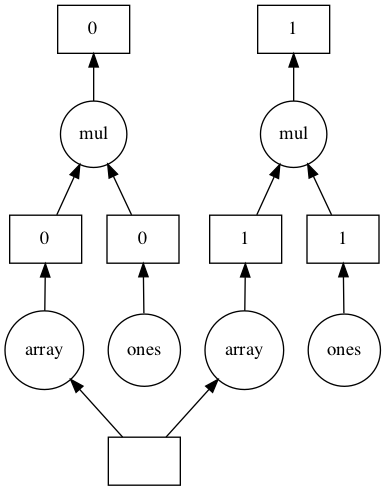

In [6]:
yda.visualize()

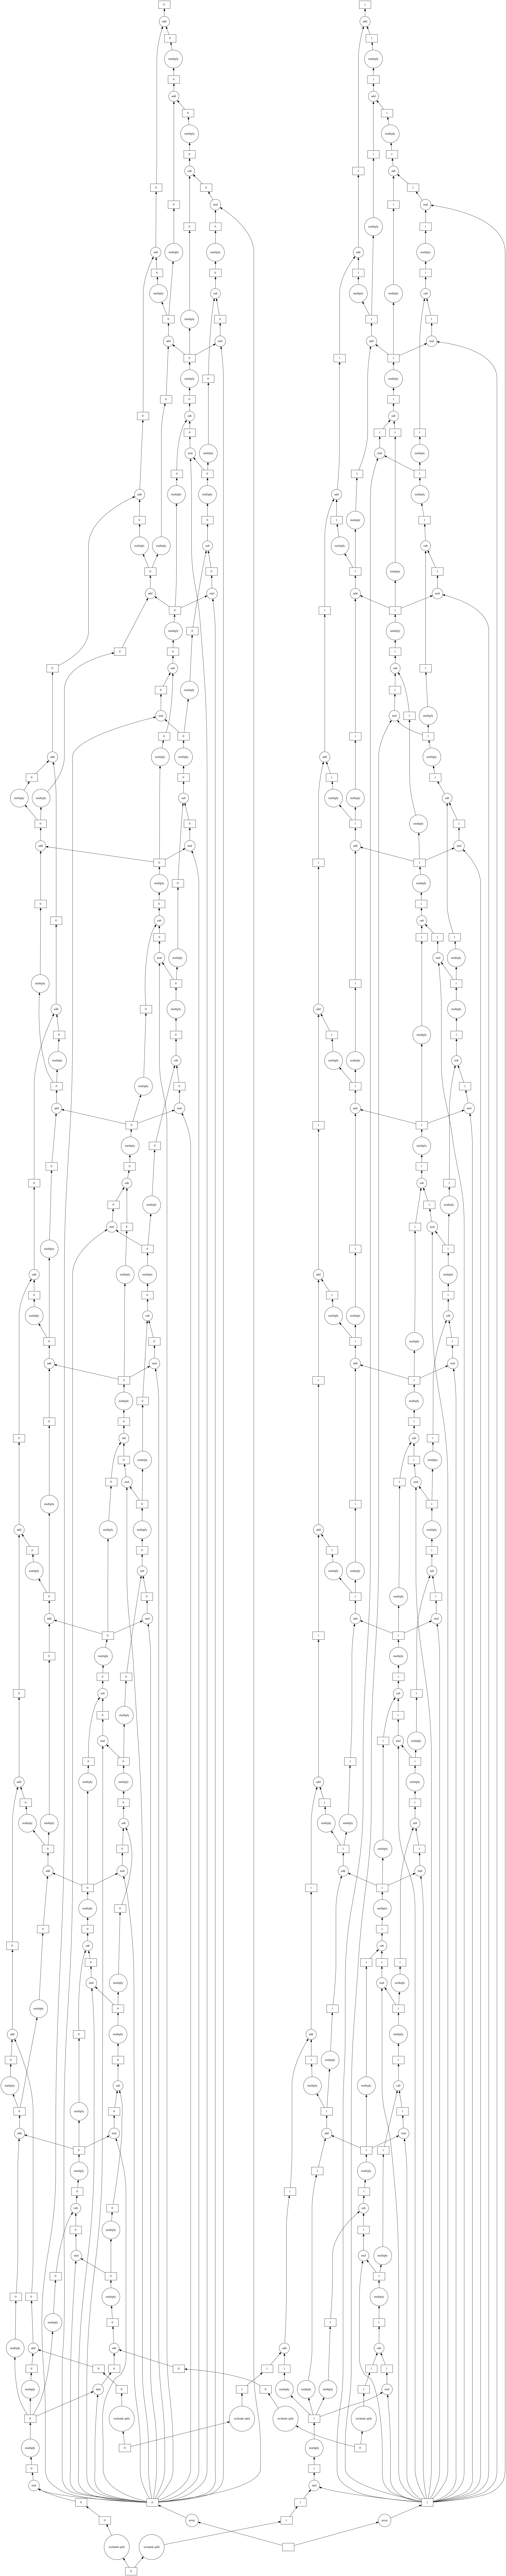

In [7]:
xinvda.visualize()

Pylops-distributed with compute for forward and adjoint

In [8]:
xda = da.ones(n, chunks=(n//2,))
dda = da.from_array(d, chunks=(n//2, n//2))
True
Ddaop = pylops_distributed.Diagonal(dda, compute=(True, True))
dottest(Ddaop, n, n, verb=True)

yda  = Ddaop.matvec(xda)
y1da = Ddaop.rmatvec(yda)
xinvda = Ddaop / yda

print('Diagonal > ', Ddaop.Op.diag)
print('D*x  = ',yda)
print('D\'*x = ',y1da)
print('D / y = ',xinvda)

<10x10 Diagonal with dtype=float64>
Dot test passed, v^T(Opu)=-29.637887 - u^T(Op^Tv)=-29.637887
Diagonal >  dask.array<array, shape=(10,), dtype=int64, chunksize=(5,)>
D*x  =  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
D'*x =  [  1.   4.   9.  16.  25.  36.  49.  64.  81. 100.]
D / y =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Comparision

In [9]:
%timeit -n 10 -r 3 Dop.matvec(x)
%timeit -n 10 -r 3 Ddaop.matvec(xda)

17.7 µs ± 2.48 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
15.3 ms ± 9.7 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


Finally we do the same with multiple dimensions

In [12]:
# serial
Dop = pylops.Diagonal(d, dir=1, dims=(5, n))
print('Diagonal > ', Dop.diag)

x = np.ones((5, n))
y = (Dop*x.flatten()).reshape(5, n)
print('D*x  = \n',y)

# distributed
Ddaop = pylops_distributed.Diagonal(dda, dir=1, dims=(5, n))
print('Diagonal > ', Ddaop.Op.diag)

xda = da.ones((5, n), chunks=(5, n//2))
yda = Ddaop.matvec(xda.flatten())
print('D*x  = ',y,'\n', yda.compute().reshape(5, n))

Diagonal >  [[ 1  2  3  4  5  6  7  8  9 10]]
D*x  = 
 [[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]]
<50x50 Diagonal with dtype=float64>
Diagonal >  dask.array<reshape, shape=(1, 10), dtype=int64, chunksize=(1, 5)>
D*x  =  [[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]] 
 [[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]]


In [13]:
%timeit -n 10 -r 3 Dop.matvec(x.flatten())
%timeit -n 10 -r 3 Ddaop.matvec(xda.flatten()).compute()

39 µs ± 7.74 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
89.5 ms ± 10.7 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
